In [4]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/haircolor_recommendations_dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
data = pd.read_csv(file_path)
print("Dataset Head:")
print(data.head())

Dataset Head:
  eye_color  gender hair_type occasion face_shape skin_color  \
0     Black    Male      Wavy   Casual       Oval     Medium   
1     Green    Male     Kinky    Party     Square       Dark   
2      Gray    Male     Curly   Casual      Round        Tan   
3     Green  Female      Wavy    Party      Heart     Medium   
4     Green  Female     Curly   Formal      Round        Tan   

  hair_color_recommendation  
0                Soft Brown  
1                Dark Brown  
2                Dark Brown  
3              Light Blonde  
4                Ash Blonde  


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:53:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized Model Accuracy: 100.00%

Confusion Matrix:
[[ 88545      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0   3122      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0  49461      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0 207258      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0   5137      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0  24649      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0  16498      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0 171555      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0  16440   

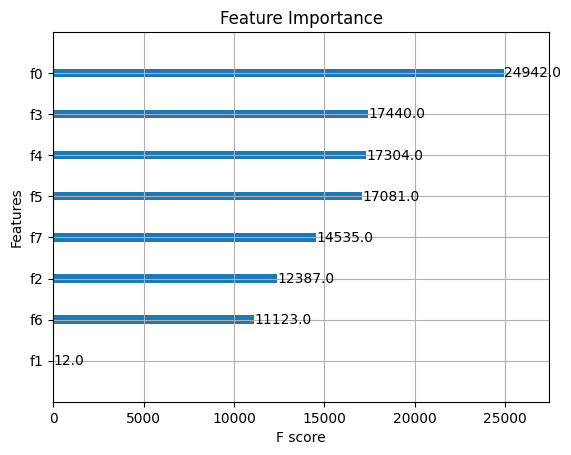

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Encode categorical features
label_encoders = {}
categorical_columns = ["eye_color", "gender", "hair_type", "occasion", "face_shape", "skin_color", "hair_color_recommendation"]

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le  # Store encoders for later use

# Feature Engineering: Adding interaction features
data['Skin_Hair_Type'] = data['skin_color'].astype(str) + "_" + data['hair_type'].astype(str)
data['Face_Occupation'] = data['face_shape'].astype(str) + "_" + data['occasion'].astype(str)

# Encode interaction features
for col in ['Skin_Hair_Type', 'Face_Occupation']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store for later use

# Split into features (X) and target (y)
X = data.drop(columns=["hair_color_recommendation"])
y = data["hair_color_recommendation"]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to XGBoost format
dtrain = xgb.DMatrix(X_scaled, label=y)

# XGBoost Model Parameters
params = {
    "objective": "multi:softmax",
    "num_class": len(data["hair_color_recommendation"].unique()),
    "max_depth": 10,
    "learning_rate": 0.03,
    "n_estimators": 500,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.5,
    "reg_alpha": 0.5,
    "min_child_weight": 3,
    "gamma": 0.1,
    "eval_metric": 'mlogloss',
}

# Train the XGBoost model with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, 'train')],
    verbose_eval=False
)

# Predict on training set
dtest = xgb.DMatrix(X_scaled)
y_pred = bst.predict(dtest)

# Model Evaluation
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)

print(f"Optimized Model Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Save Model, Encoders, and Scaler
joblib.dump(bst, "hair_color_model_xgb.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")

# Plot Feature Importance
xgb.plot_importance(bst, importance_type='weight')
plt.title("Feature Importance")
plt.show()


In [12]:
# Save Model, Encoders, and Scaler
joblib.dump(bst, "/content/drive/MyDrive/hair_color_model_xgb.pkl")

joblib.dump(label_encoders, "/content/drive/MyDrive/label_encoders.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/scaler.pkl")

['/content/drive/MyDrive/scaler.pkl']

In [14]:
import pandas as pd
import joblib
import xgboost as xgb
import numpy as np
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model, label encoders, and scaler
model = joblib.load("/content/drive/MyDrive/hair_color_model_xgb.pkl")
label_encoders = joblib.load("/content/drive/MyDrive/label_encoders.pkl")
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")

# Define input test cases
test_data = pd.DataFrame({
    'eye_color': ['Black', 'Green', 'Blue', 'Hazel'],
    'gender': ['Male', 'Female', 'Female', 'Male'],
    'hair_type': ['Wavy', 'Straight', 'Curly', 'Kinky'],
    'occasion': ['Casual', 'Party', 'Formal', 'Sport'],
    'face_shape': ['Oval', 'Square', 'Heart', 'Round'],
    'skin_color': ['Medium', 'Fair', 'Dark', 'Tan']
})

# Encode categorical features using saved label encoders
for column in test_data.columns:
    test_data[column] = label_encoders[column].transform(test_data[column])

# Feature Engineering: Adding interaction features
test_data['Skin_Hair_Type'] = test_data['skin_color'].astype(str) + "_" + test_data['hair_type'].astype(str)
test_data['Face_Occupation'] = test_data['face_shape'].astype(str) + "_" + test_data['occasion'].astype(str)

# Encode the interaction features
for col in ['Skin_Hair_Type', 'Face_Occupation']:
    test_data[col] = label_encoders[col].transform(test_data[col])

# Scale the test data
X_test_scaled = scaler.transform(test_data)

# Convert to XGBoost format
dtest = xgb.DMatrix(X_test_scaled)

# Make predictions
y_pred = model.predict(dtest)

# Decode the predicted hair color recommendations
predicted_classes = label_encoders['hair_color_recommendation'].inverse_transform(y_pred.astype(int))

# Display the results
for i, predicted_class in enumerate(predicted_classes):
    print(f"Test Case {i + 1}:")
    print(f"Predicted Hair Color Recommendation: {predicted_class}")
    print("-" * 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test Case 1:
Predicted Hair Color Recommendation: Soft Brown
--------------------------------------------------
Test Case 2:
Predicted Hair Color Recommendation: Platinum Blonde
--------------------------------------------------
Test Case 3:
Predicted Hair Color Recommendation: Ash Blonde
--------------------------------------------------
Test Case 4:
Predicted Hair Color Recommendation: Light Blonde
--------------------------------------------------
